# ML key prediction project
Before we turn to the heavy gears of ML, let us first try to understand the data.

## Understanding 1 track analysis

Import a track analysis file

In [5]:
from pickle import load
from data import get_track_path

def load_extracted_analysis(output_dir, track_id):
    path = get_track_path(output_dir, track_id)
    with open(path, 'rb') as f:
        return load(f)

track_id = '39C5FuZ8C8M0QI8CrMsPkR'
x = load_extracted_analysis('../example/', track_id)
x.keys()

dict_keys(['id', 'segments', 'duration', 'key'])

In [22]:
segments = x['segments']
duration = x['duration']
key = x['key']

In [23]:
f"song lasts {duration} seconds"

'song lasts 467.64 seconds'

[Foreplay / Long Time by Boston](https://open.spotify.com/track/39C5FuZ8C8M0QI8CrMsPkR)

![Album Cover](https://i.scdn.co/image/ab67616d0000485190ef9760e57fafd8f966d17a)

### Musical key.
From Spotify API documentation:

_The estimated overall key of the section. The values in this field ranging from 0 to 11 mapping to pitches using standard Pitch Class notation (E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on). If no key was detected, the value is -1._


In [24]:
key

5

Which we can map to pitch classes using this table: (see [this page](https://en.wikipedia.org/wiki/Pitch_class))



In [36]:
pitch_classes = {
    0: 'C (also B♯, D#)',
    1: 'C♯, D♭ (also B#)',
    2: 'D (also C#, E#)',
    3: 'D♯, E♭ (also F#)',
    4: 'E (also D#, F♭)',
    5: 'F (also E♯, G#)',
    6: 'F♯, G♭ (also E#)',
    7: 'G (also F#, A#)',
    8: 'G♯, A♭',
    9: 'A (also G#, B#)',
    10: 'A♯, B♭ (also C#)',
    11: 'B (also A#, C♭)'
}

In [37]:
pitch_classes[key]

'F (also E♯, G#)'

### Segments

In [30]:
len(segments)

1517

In [33]:
segments[1]

{'start': 0.11279,
 'duration': 0.2239,
 'confidence': 1.0,
 'pitches': [0.617,
  1.0,
  0.165,
  0.129,
  0.236,
  0.384,
  0.134,
  0.075,
  0.203,
  0.074,
  0.055,
  0.389]}

... of which '`pitches`' is the [_Chroma vector_](https://en.wikipedia.org/wiki/Chroma_feature), quoting the Spotify API docs:

_A “chroma” vector representing the pitch content of the segment, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale. _

### Visualizing the Chroma vectors
First put the data into a Pandas DataFrame, in long form.

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [79]:
dfs = []
for segment in segments:
    df = pd.DataFrame(segment)
    df = df.rename(columns={'pitches': 'pitch'})
    df['chroma'] = pitch_classes.values()
    dfs.append(df)
df = pd.concat(dfs)
df

,start,duration,confidence,pitch,chroma
0,0.00000,0.11279,0.000,1.000,"C (also B♯, D#)"
1,0.00000,0.11279,0.000,0.707,"C♯, D♭ (also B#)"
2,0.00000,0.11279,0.000,0.374,"D (also C#, E#)"
3,0.00000,0.11279,0.000,0.391,"D♯, E♭ (also F#)"
4,0.00000,0.11279,0.000,0.390,"E (also D#, F♭)"
...,...,...,...,...,...
7,466.14078,1.49923,0.382,0.672,"G (also F#, A#)"
8,466.14078,1.49923,0.382,0.563,"G♯, A♭"
9,466.14078,1.49923,0.382,0.490,"A (also G#, B#)"
10,466.14078,1.49923,0.382,0.561,"A♯, B♭ (also C#)"


In [96]:
max_pitch = df.groupby('start')['pitch'].transform(max) == df['pitch']
linedf = df[max_pitch]
linedf

,start,duration,confidence,pitch,chroma
0,0.00000,0.11279,0.000,1.0,"C (also B♯, D#)"
1,0.11279,0.22390,1.000,1.0,"C♯, D♭ (also B#)"
1,0.33669,0.13324,0.459,1.0,"C♯, D♭ (also B#)"
3,0.46993,0.20295,0.484,1.0,"D♯, E♭ (also F#)"
7,0.67288,0.24562,0.729,1.0,"G (also F#, A#)"
...,...,...,...,...,...
10,464.90414,0.19773,0.176,1.0,"A♯, B♭ (also C#)"
0,465.10187,0.53959,0.479,1.0,"C (also B♯, D#)"
5,465.64145,0.23755,0.373,1.0,"F (also E♯, G#)"
5,465.87900,0.26177,0.114,1.0,"F (also E♯, G#)"


Text(0.5, 1.0, "Chroma vectors of first 5 seconds of 'Foreplay / Long Time' track.")

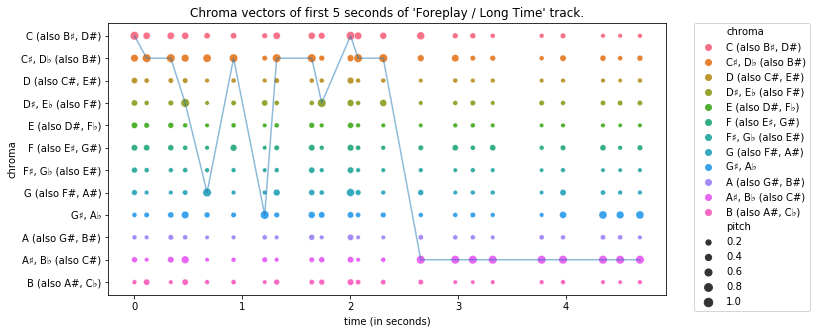

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='start', y='chroma', size='pitch',
    data=df[df['start'] < 5], ax=ax, hue='chroma')
sns.lineplot(x='start', y='chroma', alpha=0.5,
    data=linedf[linedf['start'] < 5], ax=ax, sort=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('time (in seconds)')
plt.title('Chroma vectors of first 5 seconds of \'Foreplay / Long Time\' track.')

## Understanding the data loading mechanism

In [5]:
from meta import Meta
from data import get_meta_path, get_track_path

output_dir = '../dataset'
meta = Meta.load(output_dir)
get_track_path(output_dir, meta.track_ids[0])

'../dataset/39C5FuZ8C8M0QI8CrMsPkR.pickle'